# Random Forest, Gradient Boosting y AdaBoost

### Docente: M.Sc. Richard Fernández 

### Comprensión del negocio

Objetivo del negocio: Incrementar el marketshare de "Perú Bank" en el mercado de depósitos a plazo.

Objetivo de ML: Predecir la probabilidad de que un cliente acepte el producto de depósito a plazo que ofrece "Perú Bank" mediante el canal de Call Center.

### Comprensión de los datos 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('bank_deposit.csv')

In [3]:
data.head(5)

,idcliente,duration,previous,housing,campaign,loan,default,target,muestra
0,1,261,0,1,1,0,0,0,1
1,2,50,0,1,1,0,0,0,1
2,3,1492,0,1,1,0,0,0,1
3,4,104,0,1,1,0,0,0,1
4,5,13,0,1,1,0,0,0,1


In [4]:
data.dtypes

idcliente    int64
duration     int64
previous     int64
housing      int64
campaign     int64
loan         int64
default      int64
target       int64
muestra      int64
dtype: object

In [5]:
data['housing'] = data['housing'].astype(object)
data['loan'] = data['loan'].astype(object)
data['default'] = data['default'].astype(object)

In [6]:
data.dtypes

idcliente     int64
duration      int64
previous      int64
housing      object
campaign      int64
loan         object
default      object
target        int64
muestra       int64
dtype: object

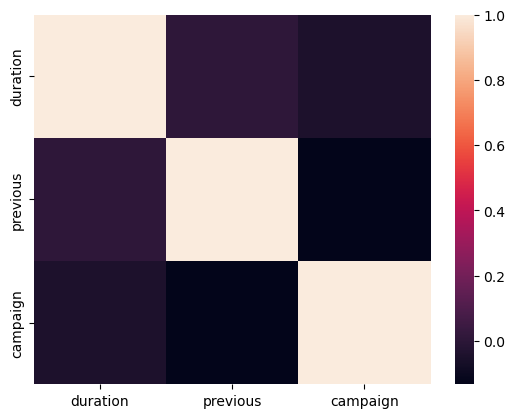

In [7]:
#Heatmap
sns.heatmap(data.loc[:,['duration','previous','campaign']].corr(method = "spearman"))
plt.show()

In [8]:
#Prueba de Correlación
#Ho: no existe correlación entre las variables
#Ha: existe correlación entre las variables

In [9]:
data.loc[:,['duration','previous','campaign']].corr(method = "spearman")

,duration,previous,campaign
duration,1.000000,0.007392,-0.045111
previous,0.007392,1.000000,-0.133380
campaign,-0.045111,-0.133380,1.000000


In [10]:
data['target'].dtype

dtype('int64')

In [11]:
data['target'] = data['target'].astype('int64')

In [12]:
data['target'].dtype

dtype('int64')

In [13]:
data.target.value_counts()

target
0    5289
1    5289
Name: count, dtype: int64

In [14]:
100*data['target'].value_counts(normalize=True)

target
0    50.0
1    50.0
Name: proportion, dtype: float64

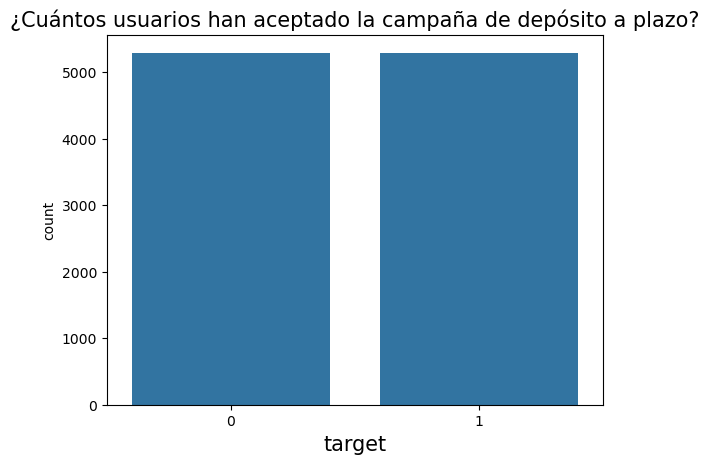

In [15]:
sns.countplot(data = data, x = 'target')
plt.xlabel('target', fontsize = 15)
plt.title('¿Cuántos usuarios han aceptado la campaña de depósito a plazo?', fontsize = 15)
plt.show()

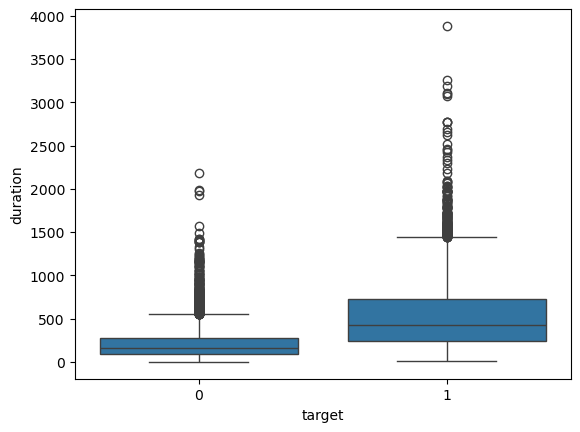

In [16]:
sns.boxplot(x='target',y='duration',data=data)
plt.show()

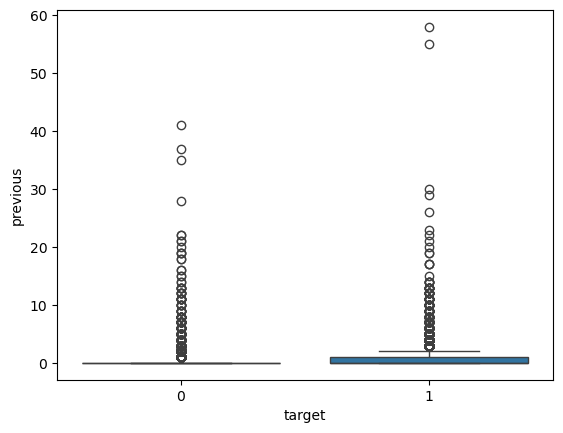

In [17]:
sns.boxplot(x='target',y='previous',data=data)
plt.show()

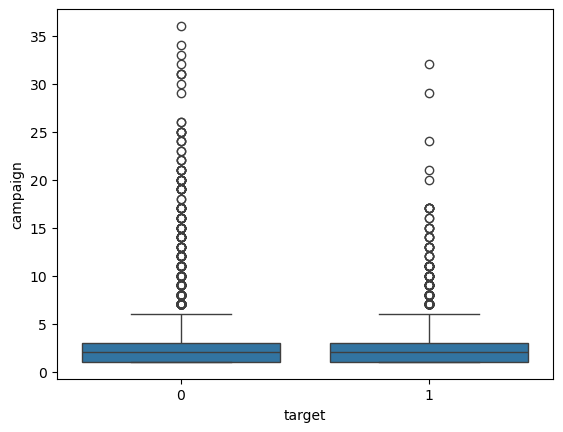

In [18]:
sns.boxplot(x='target',y='campaign',data=data)
plt.show()

##### Test Levene

In [19]:
#Ho: los datos proceden de distribuciones con la misma varianza
#Ha: los datos no proceden de distribuciones con la misma varianza

#Si pvalor < 5% => Se rechaza Ho, al 95% de confianza, los datos no proceden de distribuciones con la misma varianza
#Si pvalor > 5% => No se rechaza Ho, al 95% de confianza, los datos proceden de distribuciones con la misma varianza

In [20]:
#Target vs Duration

duration_acepta = data.loc[data.target == 1, 'duration']
duration_noacepta = data.loc[data.target == 0, 'duration']

levene_test = ss.levene(duration_acepta, duration_noacepta, center='median')
levene_test

LeveneResult(statistic=1289.4402200805537, pvalue=1.4795573243984309e-266)

In [21]:
#Target vs Previous

previous_acepta = data.loc[data.target == 1, 'previous']
previous_noacepta = data.loc[data.target == 0, 'previous']

levene_test = ss.levene(previous_acepta, previous_noacepta, center='median')
levene_test

LeveneResult(statistic=215.3699911866115, pvalue=2.757636101689391e-48)

In [22]:
#Target vs Campaign

campaign_acepta = data.loc[data.target == 1, 'campaign']
campaign_noacepta = data.loc[data.target == 0, 'campaign']

levene_test = ss.levene(campaign_acepta, campaign_noacepta, center='median')
levene_test

LeveneResult(statistic=111.01660275863678, pvalue=7.877250722780477e-26)

##### Test U-test o Test U de Mann-Whitney-Wilcoxon

In [23]:
#Ho: los datos proceden de distribuciones con la misma mediana
#Ha: los datos no proceden de distribuciones con la misma mediana

#Si pvalor < 5% => Se rechaza Ho, al 95% de confianza, los datos no proceden de distribuciones con la misma mediana
#Si pvalor > 5% => No se rechaza Ho, al 95% de confianza, los datos proceden de distribuciones con la misma mediana

In [24]:
! pip install pingouin

  Using cached pingouin-0.5.5-py3-none-any.whl.metadata (19 kB)
  Using cached pandas_flavor-0.6.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached statsmodels-0.14.1-cp38-cp38-win_amd64.whl.metadata (9.8 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached xarray-2023.1.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached pingouin-0.5.5-py3-none-any.whl (204 kB)
Using cached pandas_flavor-0.6.0-py3-none-any.whl (7.2 kB)
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.0 MB 660.6 kB/s eta 0:00:16
   ---------------------------------------- 0.0/10.0 MB 393.8 kB/s eta 0:00:26
   ---------------------------------------- 0.0/10.0 MB 393.8 kB/s eta 0:00:26
   ---------------------------------------- 0.0/10.0 MB 393.8 kB/s eta 0:00:26
   ---------------------------------------- 0.0/10.0 MB 393.8 kB/s eta 0:00:26
   -------------

In [25]:
import pingouin as pg

In [26]:
#Target vs Duration
pg.mwu(x=duration_acepta, y=duration_noacepta, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,22591878.5,two-sided,0.0,0.615233,0.807617


In [27]:
#Target vs Duration
pg.mwu(x=duration_acepta, y=duration_noacepta, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,22591878.5,two-sided,0.0,0.615233,0.807617


In [28]:
#Target vs Previous
pg.mwu(x=previous_acepta, y=previous_noacepta, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,16829530.5,two-sided,3.813065e-122,0.203247,0.601624


In [29]:
#Target vs Campaign
pg.mwu(x=campaign_acepta, y=campaign_noacepta, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,11913400.5,two-sided,4.638831e-44,-0.148237,0.425881


housing     0     1
target             
0        2176  3113
1        3354  1935


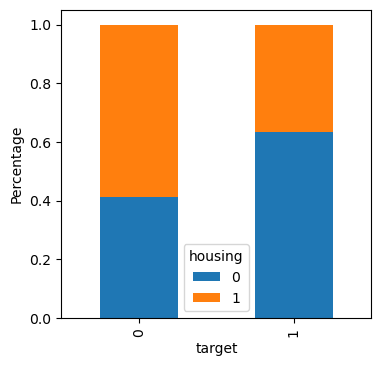

In [30]:
print(pd.crosstab(data["target"],data["housing"]))
t = pd.crosstab(data["target"],data["housing"])
t.div(t.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("target")
plt.ylabel("Percentage")
plt.show()

Las personas con uncredito hipotecario prefieren amortizar su capital a 


loan       0    1
target           
0       4359  930
1       4805  484


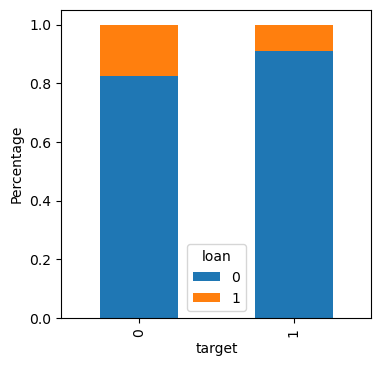

In [31]:
print(pd.crosstab(data["target"],data["loan"]))
t = pd.crosstab(data["target"],data["loan"])
t.div(t.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("target")
plt.ylabel("Percentage")
plt.show()

##### Prueba Chi-Cuadrado

In [32]:
#Ho: no existe dependencia entre las variables
#Ha: existe dependencia entre las variables

#Si pvalor < 5% => Se rechaza Ho, al 95% de confianza, existe dependencia entre las variables
#Si pvalor > 5% => No se rechaza Ho, al 95% de confianza, no existe dependencia entre las variables

In [33]:
#Target vs Housing

contigencia = pd.crosstab(data['target'], data['housing'])
c, p, dof, expected = chi2_contingency(contigencia) 
print(c, p)

524.9428331418026 3.557728213453099e-116


housing tiene mas peso en el target

In [34]:
#Target vs Loan

contigencia = pd.crosstab(data['target'], data['loan'])
c, p, dof, expected = chi2_contingency(contigencia) 
print(c, p)

161.65498241381164 4.921141785848781e-37


### Preparación de los datos 

In [35]:
data['c_housing'] = LabelEncoder().fit_transform(data.housing.values)
data['c_loan'] = LabelEncoder().fit_transform(data.loan.values)

In [36]:
data.head(5)

,idcliente,duration,previous,housing,campaign,loan,default,target,muestra,c_housing,c_loan
0,1,261,0,1,1,0,0,0,1,1,0
1,2,50,0,1,1,0,0,0,1,1,0
2,3,1492,0,1,1,0,0,0,1,1,0
3,4,104,0,1,1,0,0,0,1,1,0
4,5,13,0,1,1,0,0,0,1,1,0


In [37]:
X = data[['c_housing','c_loan','duration']]
y = data['target']

In [38]:
X = X.to_numpy()

In [39]:
X[0:5]

array([[   1,    0,  261],
       [   1,    0,   50],
       [   1,    0, 1492],
       [   1,    0,  104],
       [   1,    0,   13]], dtype=int64)

In [40]:
y = y.to_numpy()

In [41]:
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [43]:
X_train[0:5]

array([[   1,    0, 1080],
       [   1,    0,  204],
       [   0,    0,  140],
       [   0,    0,  373],
       [   0,    0,  194]], dtype=int64)

In [44]:
X_test[0:5]

array([[  0,   0, 263],
       [  0,   0, 597],
       [  0,   0, 150],
       [  0,   0, 917],
       [  1,   0, 404]], dtype=int64)

In [45]:
X_train_orig = X_train
X_test_orig = X_test

In [46]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [47]:
X_train[0:5]

array([[ 1.05317258, -0.39338138,  2.00876968],
       [ 1.05317258, -0.39338138, -0.50165504],
       [-0.949512  , -0.39338138, -0.68506507],
       [-0.949512  , -0.39338138, -0.01733795],
       [-0.949512  , -0.39338138, -0.53031286]])

In [48]:
X_test[0:5]

array([[-0.97941782, -0.39051946, -0.32766412],
       [-0.97941782, -0.39051946,  0.63785382],
       [-0.97941782, -0.39051946, -0.65432139],
       [-0.97941782, -0.39051946,  1.56290095],
       [ 1.02101471, -0.39051946,  0.07993477]])

### Modelado

##### Ramdom Forest

In [49]:
#Tuning
#n_estimators: Número de árboles
#max_features: Cantidad de variables a considerar al buscar el mejor split
#max_depth: Profundidad del árbol

param_grid_rf = {
    'n_estimators': [300, 400, 500, 600, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 3, 4, 5, 6]
}

In [50]:
grid_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf,refit=True,verbose=2,cv=5)
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.6s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.6s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.7s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.6s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.6s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.6s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=2, max_features=sqrt, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300, 400, 500, 600, 700]},
             verbose=2)

In [51]:
print(grid_rf.best_estimator_)

RandomForestClassifier(max_depth=5, max_features='log2', n_estimators=700)


In [52]:
classifier_rf = RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=400).fit(X_train, y_train)

In [53]:
feature_scores_rf = pd.Series(classifier_rf.feature_importances_, index=['housing','loan','duration']).sort_values(ascending=False)
feature_scores_rf

duration    0.837837
housing     0.124873
loan        0.037290
dtype: float64

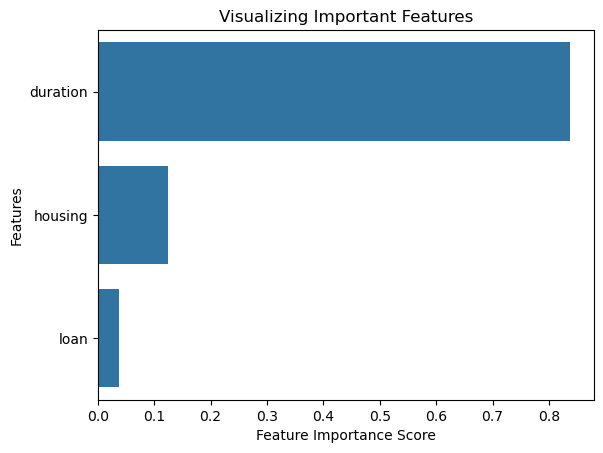

In [54]:
sns.barplot(x=feature_scores_rf, y=feature_scores_rf.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

##### Gradient Boosting

In [55]:
#Tuning
#n_estimators: Número de árboles
#max_features: Cantidad de variables a considerar al buscar el mejor split
#max_depth: Profundidad del árbol

param_grid_gb = {
    'n_estimators': [300, 400, 500, 600, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 3, 4, 5, 6]
}

In [58]:
grid_gb = GridSearchCV(GradientBoostingClassifier(),param_grid_gb,refit=True,verbose=2,cv=5)
grid_gb.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.3s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.3s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.3s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.3s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=300; total time=   0.3s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.4s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=400; total time=   0.5s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=500; total time=   0.6s
[CV] END ...max_depth=2, max_features=sqrt, n_e

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [300, 400, 500, 600, 700]},
             verbose=2)

In [64]:
print(grid_gb.best_estimator_)

GradientBoostingClassifier(max_depth=2, max_features='sqrt', n_estimators=300)


In [66]:
classifier_gb = GradientBoostingClassifier(max_depth=2, max_features='sqrt', n_estimators=300).fit(X_train, y_train)

In [67]:
feature_scores_gb = pd.Series(classifier_gb.feature_importances_, index=['housing','loan','duration']).sort_values(ascending=False)
feature_scores_gb

duration    0.827694
housing     0.135702
loan        0.036604
dtype: float64

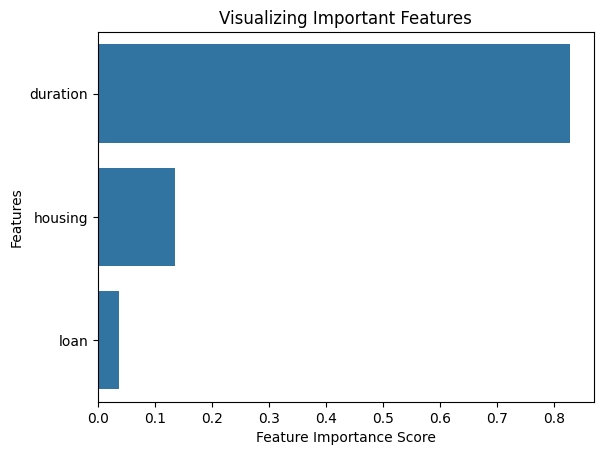

In [68]:
sns.barplot(x=feature_scores_gb, y=feature_scores_gb.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

##### AdaBoost

In [69]:
#Tuning
#n_estimators: Número de árboles
#learning_rate: peso aplicado a cada clasificador en cada iteración,
#               una tasa de aprendizaje más alta aumenta la contribución de cada clasificador.
#algorith: se usa para la convergencia de los clasificadores

param_grid_ab = {
    'n_estimators': [300, 400, 500, 600, 700],
    'learning_rate': [0.001, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [70]:
grid_ab = GridSearchCV(AdaBoostClassifier(),param_grid_ab,refit=True,verbose=2,cv=5)
grid_ab.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=300; total time=   1.1s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=300; total time=   1.0s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=300; total time=   1.0s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=300; total time=   0.9s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=300; total time=   0.9s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=400; total time=   1.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=400; total time=   1.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=400; total time=   1.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=400; total time=   1.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=400; total time=   1.1s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=500; total time=   1.5s
[CV] END algor

C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=300; total time=   1.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=300; total time=   1.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=400; total time=   1.7s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=400; total time=   1.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=400; total time=   1.7s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=400; total time=   1.9s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=400; total time=   1.9s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=500; total time=   2.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=500; total time=   2.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=500; total time=   2.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=500; total time=   2.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=500; total time=   2.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=600; total time=   3.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=600; total time=   2.9s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=600; total time=   2.9s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=600; total time=   2.8s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=600; total time=   3.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=700; total time=   3.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=700; total time=   3.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=700; total time=   3.8s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=700; total time=   3.1s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=700; total time=   3.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   1.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   1.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=400; total time=   1.8s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=400; total time=   2.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=400; total time=   2.1s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=400; total time=   2.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=400; total time=   2.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=500; total time=   2.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=500; total time=   2.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=500; total time=   2.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=500; total time=   3.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=500; total time=   2.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600; total time=   3.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600; total time=   2.8s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600; total time=   3.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600; total time=   3.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=600; total time=   2.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700; total time=   3.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700; total time=   3.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700; total time=   3.7s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700; total time=   3.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=700; total time=   3.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=300; total time=   1.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=300; total time=   1.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=300; total time=   1.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=300; total time=   1.1s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=300; total time=   1.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=400; total time=   1.7s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=400; total time=   1.8s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=400; total time=   1.7s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=400; total time=   1.9s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=400; total time=   2.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=500; total time=   2.0s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=500; total time=   2.1s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=500; total time=   2.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=500; total time=   2.5s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=500; total time=   2.2s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=600; total time=   2.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=600; total time=   2.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=600; total time=   2.6s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=600; total time=   3.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=600; total time=   3.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=700; total time=   4.1s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=700; total time=   4.4s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=700; total time=   3.9s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=700; total time=   3.8s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=700; total time=   3.3s


C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.001, 0.1, 1],
                         'n_estimators': [300, 400, 500, 600, 700]},
             verbose=2)

In [71]:
print(grid_ab.best_estimator_)

AdaBoostClassifier(learning_rate=0.1, n_estimators=300)


In [72]:
classifier_ab = AdaBoostClassifier(learning_rate=0.1, 
                                   n_estimators=300).fit(X_train, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [74]:
feature_scores_ab = pd.Series(classifier_ab.feature_importances_, index=['housing','loan','duration']).sort_values(ascending=False)
feature_scores_ab

duration    0.800000
housing     0.113333
loan        0.086667
dtype: float64

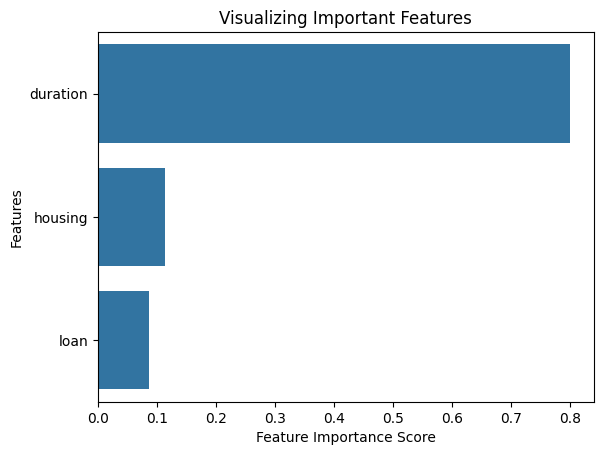

In [75]:
sns.barplot(x=feature_scores_ab, y=feature_scores_ab.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Evaluación 

##### Random Forest

In [76]:
y_pred_rf = classifier_rf.predict(X_test)

In [77]:
confusion_matrix(y_test, y_pred_rf)

array([[800, 229],
       [243, 844]], dtype=int64)

Confusion matrix, without normalization
[[800 229]
 [243 844]]
Normalized confusion matrix
[[0.77745384 0.22254616]
 [0.22355106 0.77644894]]


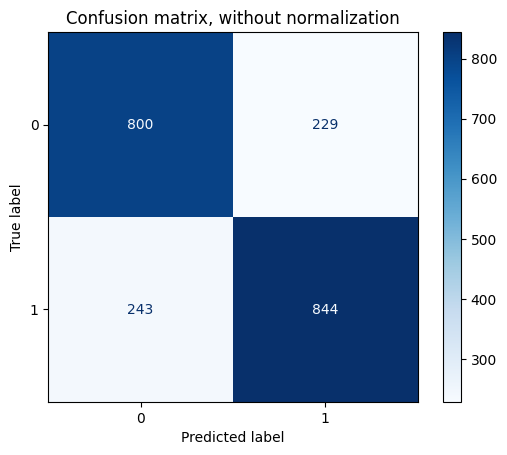

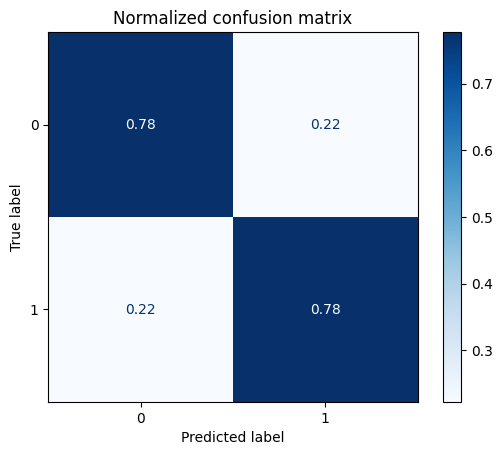

In [78]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(classifier_rf, X_test, y_test,
                                                 #display_labels=y_test,
                                                 cmap=plt.cm.Blues,
                                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [79]:
y_pred_prob_rf = classifier_rf.predict_proba(X_test)

In [80]:
false_positive_rate_rf, true_positive_rate_rf, thresholds = roc_curve(y_test, y_pred_prob_rf[:,1])

In [81]:
roc_auc_rf = auc(false_positive_rate_rf, true_positive_rate_rf)
roc_auc_rf

0.8592907790005211

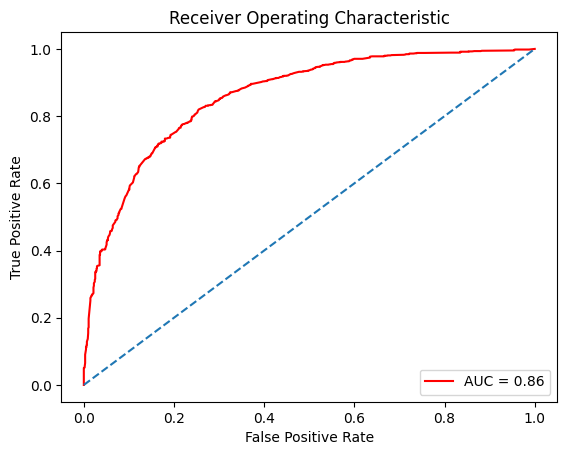

In [82]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_rf,true_positive_rate_rf, color='red',label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1029
           1       0.79      0.78      0.78      1087

    accuracy                           0.78      2116
   macro avg       0.78      0.78      0.78      2116
weighted avg       0.78      0.78      0.78      2116



##### Gradient Boosting

In [86]:
y_pred_gb = classifier_gb.predict(X_test)

In [87]:
confusion_matrix(y_test, y_pred_gb)

array([[788, 241],
       [234, 853]], dtype=int64)

Confusion matrix, without normalization
[[788 241]
 [234 853]]
Normalized confusion matrix
[[0.76579203 0.23420797]
 [0.21527139 0.78472861]]


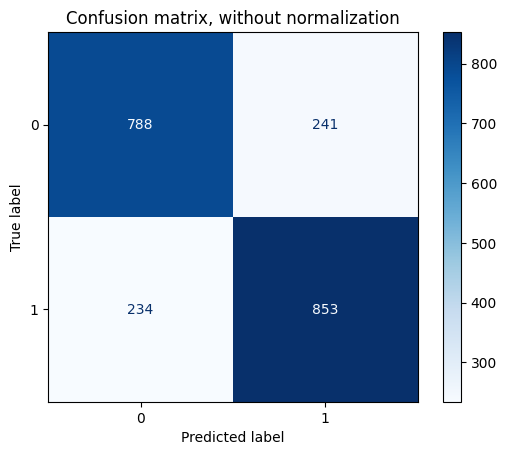

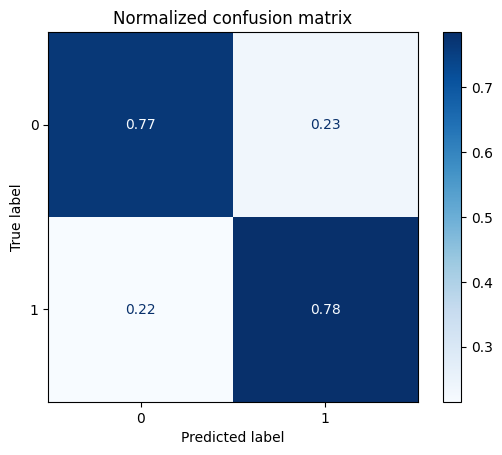

In [88]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(classifier_gb, X_test, y_test,
                                                 #display_labels=y_test,
                                                 cmap=plt.cm.Blues,
                                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


In [89]:
y_pred_prob_gb = classifier_gb.predict_proba(X_test)

In [90]:
false_positive_rate_gb, true_positive_rate_gb, thresholds = roc_curve(y_test, y_pred_prob_gb[:,1])

In [91]:
roc_auc_gb = auc(false_positive_rate_gb, true_positive_rate_gb)
roc_auc_gb


0.859866538283075

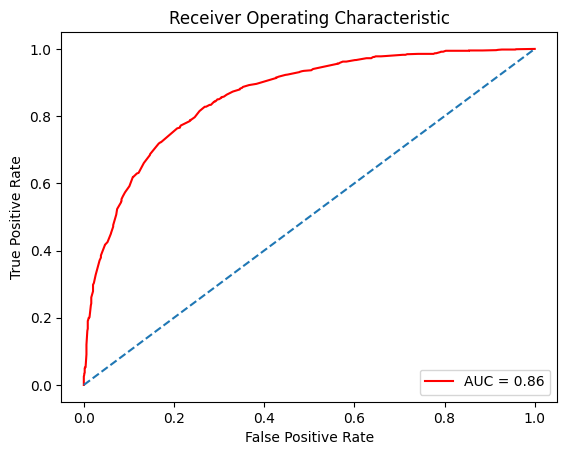

In [92]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_gb,true_positive_rate_gb, color='red',label = 'AUC = %0.2f' % roc_auc_gb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [93]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1029
           1       0.78      0.78      0.78      1087

    accuracy                           0.78      2116
   macro avg       0.78      0.78      0.78      2116
weighted avg       0.78      0.78      0.78      2116



##### AdaBoost

In [94]:
y_pred_ab = classifier_ab.predict(X_test)

In [95]:
confusion_matrix(y_test, y_pred_ab)

array([[802, 227],
       [250, 837]], dtype=int64)

Confusion matrix, without normalization
[[802 227]
 [250 837]]
Normalized confusion matrix
[[0.77939747 0.22060253]
 [0.2299908  0.7700092 ]]


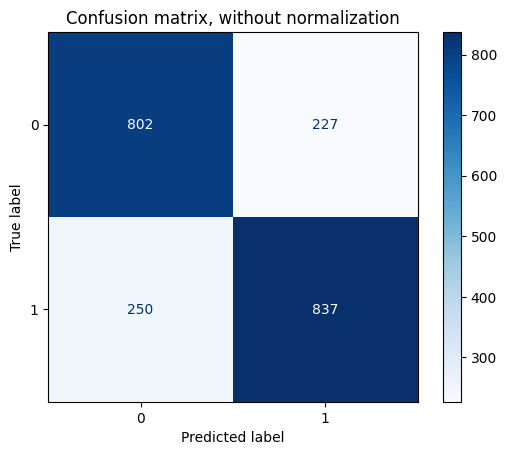

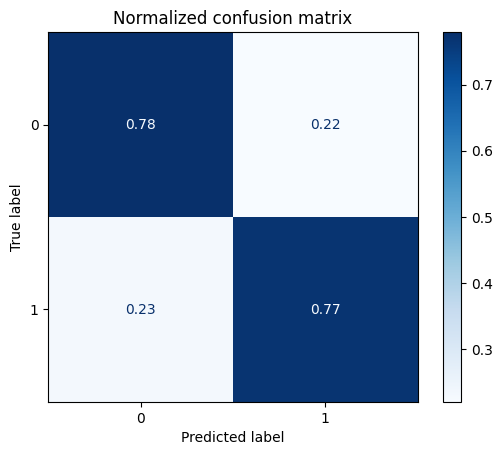

In [96]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(classifier_ab, X_test, y_test,
                                                 #display_labels=y_test,
                                                 cmap=plt.cm.Blues,
                                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


In [97]:
y_pred_prob_ab = classifier_ab.predict_proba(X_test)

In [98]:
false_positive_rate_ab, true_positive_rate_ab, thresholds = roc_curve(y_test, y_pred_prob_ab[:,1])

In [99]:
roc_auc_ab = auc(false_positive_rate_ab, true_positive_rate_ab)
roc_auc_ab


0.8571088837690418

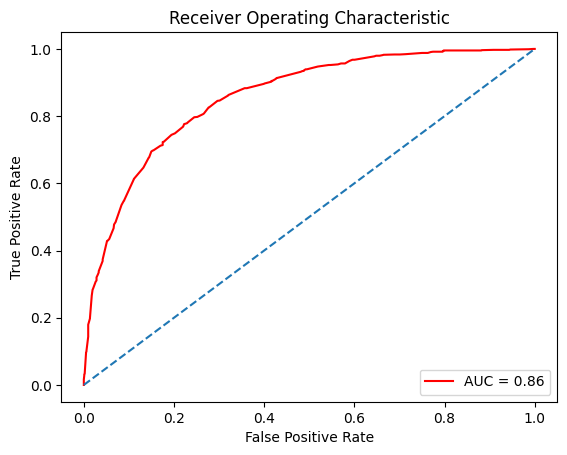

In [100]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_ab,true_positive_rate_ab, color='red',label = 'AUC = %0.2f' % roc_auc_ab)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [101]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1029
           1       0.79      0.77      0.78      1087

    accuracy                           0.77      2116
   macro avg       0.77      0.77      0.77      2116
weighted avg       0.77      0.77      0.77      2116



In [102]:
#Comparar los modelos y seleccionar el más adecuado.

In [104]:
dataf = pd.concat([pd.DataFrame(X_test_orig),pd.DataFrame(y_test),pd.DataFrame(y_pred_gb),pd.DataFrame(y_pred_prob_gb)],axis=1)

In [105]:
dataf.head(5)

,0,1,2,0,0,0,1
0,0,0,263,1,1,0.244312,0.755688
1,0,0,597,1,1,0.162471,0.837529
2,0,0,150,0,0,0.563523,0.436477
3,0,0,917,1,1,0.086421,0.913579
4,1,0,404,1,0,0.506688,0.493312


In [107]:
dataf.columns = ['c_housing','c_loan','duration','Target','Target_Pred','Target_Pred_Prob_0','Target_Pred_Prob_1']

In [108]:
dataf.head(10)

,c_housing,c_loan,duration,Target,Target_Pred,Target_Pred_Prob_0,Target_Pred_Prob_1
0,0,0,263,1,1,0.244312,0.755688
1,0,0,597,1,1,0.162471,0.837529
2,0,0,150,0,0,0.563523,0.436477
3,0,0,917,1,1,0.086421,0.913579
4,1,0,404,1,0,0.506688,0.493312
5,1,0,25,0,0,0.987601,0.012399
6,1,0,940,1,1,0.100705,0.899295
7,0,0,63,0,0,0.860031,0.139969
8,0,0,585,0,1,0.162471,0.837529
9,0,0,212,1,1,0.291288,0.708712


In [109]:
dataf = pd.concat([pd.DataFrame(X_test_orig),pd.DataFrame(y_test),pd.DataFrame(y_pred),pd.DataFrame(y_pred_prob)],axis=1)

NameError: name 'y_pred' is not defined

In [110]:
dataf.head(10)

,c_housing,c_loan,duration,Target,Target_Pred,Target_Pred_Prob_0,Target_Pred_Prob_1
0,0,0,263,1,1,0.244312,0.755688
1,0,0,597,1,1,0.162471,0.837529
2,0,0,150,0,0,0.563523,0.436477
3,0,0,917,1,1,0.086421,0.913579
4,1,0,404,1,0,0.506688,0.493312
5,1,0,25,0,0,0.987601,0.012399
6,1,0,940,1,1,0.100705,0.899295
7,0,0,63,0,0,0.860031,0.139969
8,0,0,585,0,1,0.162471,0.837529
9,0,0,212,1,1,0.291288,0.708712


In [111]:
dataf.columns = ['c_housing','c_loan','duration','Target','Target_Pred','Target_Pred_Prob_0','Target_Pred_Prob_1']

In [66]:
dataf.head(10)

,c_housing,c_loan,duration,Target,Target_Pred,Target_Pred_Prob_0,Target_Pred_Prob_1
0,1,0,1080,1.0,1.0,0.278378,0.721622
1,1,0,204,1.0,1.0,0.152051,0.847949
2,0,0,140,0.0,0.0,0.596062,0.403938
3,0,0,373,1.0,1.0,0.127309,0.872691
4,0,0,194,1.0,0.0,0.535681,0.464319
5,0,0,387,0.0,0.0,0.937934,0.062066
6,1,1,250,1.0,1.0,0.144872,0.855128
7,0,0,132,0.0,0.0,0.905904,0.094096
8,0,0,305,0.0,1.0,0.153567,0.846433
9,1,0,156,1.0,1.0,0.321489,0.678511


In [67]:
quantiles = dataf['Target_Pred_Prob_1'].quantile(q=[0.20,0.40,0.60,0.80])
quantiles

0.2    0.175154
0.4    0.338303
0.6    0.695413
0.8    0.805683
Name: Target_Pred_Prob_1, dtype: float64

In [68]:
dataf.to_csv('D:/dataf.csv', index = False)

### Tarea

1. Para la base de datos dataf, crear una variable "score1", con las categorías: Muy alto, alto, medio, bajo y muy bajo. 
Usar: Target_Pred_Prob_1

2. Para la base de datos dataf, crear una variable "score2", con las categorías: Muy alto, alto, medio, bajo y muy bajo. 
Usar: La tabla de deciles vs Target

3. Proponer estrategias focalizadas para cada segmento. 

4. Revisar los siguientes enlaces:
    #RandomForestClassifier
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    #Random Forest con Python 
    #https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

5. Tunear el modelo con otros valores.

Graficar en una grafica los 3 modelos